In [30]:
from matplotlib import pyplot as plt
from matplotlib import colormaps as clm
import numpy as np
import Archives_tests.analysisFunctions as aF
from scipy.signal import find_peaks, correlate
from scipy.ndimage import gaussian_filter, median_filter
from scipy.stats import sem
import seaborn as sns
import seaborn_image as snsi
import cmcrameri.cm as cmc

# import tifffile as tff

# cmap = 'cmc.batlow'
# sns.set_palette(cmap)

## Raw data

### open data

In [6]:
pathBase = r"Z:\gGermain\2014_09_17\3"

violet = np.loadtxt(pathBase + "\\405.csv", skiprows=1, delimiter=',')
violet = violet[:,1]
blue = np.loadtxt(pathBase + "\\470.csv", skiprows=1, delimiter=',')
blue = blue[:,1]
green = np.loadtxt(pathBase + "\\530.csv", skiprows=1, delimiter=',')
green = green[:,1]
red = np.loadtxt(pathBase + "\\625.csv", skiprows=1, delimiter=',')
red = red[:,1]
# LSCI = np.loadtxt(pathBase + "\\785std.csv", delimiter=',', skiprows=1)
# LSCI = LSCI[:,1]

violet_t = np.load(pathBase + "\\405ts.npy")
blue_t = np.load(pathBase + "\\470ts.npy")
green_t = np.load(pathBase + "\\530ts.npy")
red_t = np.load(pathBase + "\\625ts.npy")
# LSCI_t = np.load(pathBase + "\\785ts.npy")
# LSCI_t = LSCI_t
# print(len(LSCI))

# np.savetxt(pathBase+'\\blue_t.txt', blue_t)       # debugging timestamps



### plot data

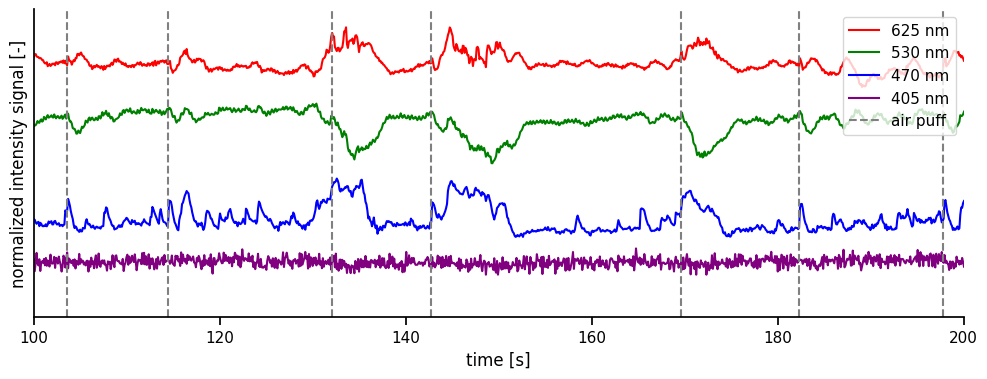

In [32]:
sns.set_context('notebook')

violet = aF.normalizeData(violet, dim=1)
blue = aF.normalizeData(blue, dim=1)
green = aF.normalizeData(green, dim=1)
red = aF.normalizeData(red, dim=1)
# LSCI = aF.normalizeData(LSCI, dim=1) *-1 + 1

## AP approx
AP = np.array([  12.01,   35.2 ,   46.51,   74.12,   91.14,  103.63,  114.48,
        132.14,  142.77,  169.61,  182.33,  197.83,  209.56,  223.5 ,
        239.35,  252.31,  263.77,  279.97,  297.53,  310.62,  323.38,
        335.92,  365.67,  383.93,  402.83,  417.51,  430.48,  440.9 ,
        456.7 ,  468.25,  480.64])


fig = plt.figure(figsize=(12, 4))
# plt.plot(LSCI_t, LSCI+4.4, color='darkred', label='785 nm')
plt.plot(red_t, red+3.3, color='red', label='625 nm')
plt.plot(green_t, green+2.2, color='green', label='530 nm')
plt.plot(blue_t, blue+1.1, color='blue', label='470 nm')
plt.plot(violet_t, violet, color='purple', label='405 nm')
plt.vlines(AP, -0.1, 4.5, color='grey', linestyles='--', label='air puff')


plt.legend(loc='upper right')
plt.ylim(-0.1, 4.5)
plt.xlim(100, 200)
# plt.xlim(0, 80)
plt.xlabel("time [s]")
plt.ylabel("normalized intensity signal [-]")
ax = plt.gca()
ax.set_yticklabels([])
ax.set_yticks([])
sns.despine()
# plt.tight_layout()

# plt.savefig("raw_signal_zoom.png", dpi=600)



### Aligned on air puffs

The lag is 0.06 s


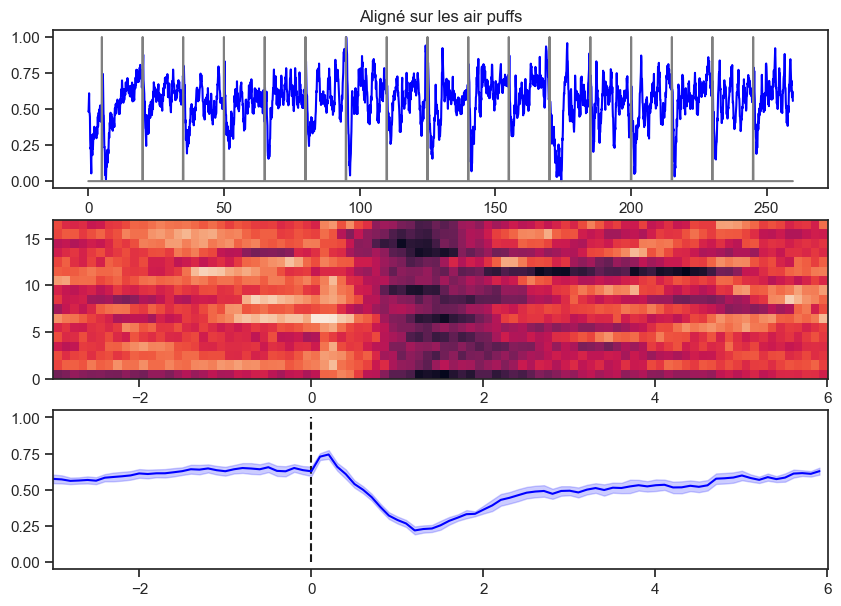

In [16]:
FPS = 50

# time, sig, col = (violet_t, violet, 'purple')
time, sig, col = (blue_t, blue, 'blue')
# time, sig, col = (green_t, green, 'green')
# time, sig, col = (red_t, red, 'red')
# time, sig, col = (LSCI_t, gaussian_filter(LSCI, sigma=2), 'darkred')


AP_idx = []
nChannels=5
AP_begin = 5
percycle=15
FPSc = FPS/nChannels
framespcycles = int(FPSc*percycle)
ncycles = int(len(time)//framespcycles)
AP_times = np.array(list(range(ncycles)))*15+5

for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(time-ti)))

# Dirac où AP dans times series
AP_series = np.zeros(len(time))
AP_series[AP_idx] = 1

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(3, 1, 1)
plt.title('Aligné sur les air puffs')
ax1.plot(time, sig, color=col)
ax1.plot(time, AP_series, color='grey')
# ax1.set_xlim(0, 40)

inf = 30
sup = 60
aligned_data = np.zeros((len(AP_idx), inf+sup))
for i in range(len(AP_idx)):
  aligned_data[i,:] = sig[int(AP_idx[i]-inf):int(AP_idx[i]+sup)]
ax2 = plt.subplot(3, 1, 2)
ax2.imshow(aligned_data, origin='lower', extent=[time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]], 0, ncycles], aspect='auto')

avg_data = np.mean(aligned_data, axis=0)
# std_data = np.std(aligned_data, axis=0)
std_data = sem(aligned_data, axis=0)
ax3 = plt.subplot(3, 1, 3)
ax3.vlines(0, 0, 1, color='k', linestyles='--')
ax3.plot(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data, color=col)
ax3.fill_between(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data-std_data, avg_data+std_data, color=col, alpha=0.2)
ax3.set_xlim(time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]])

correlation = correlate(AP_series, sig)
lag = np.argmax(correlation)
print('The lag is', (len(time)-lag)/FPS, 's')
# plt.plot(correlation)
# plt.savefig('raster.png', dpi=600)
plt.show()



### 4 signaux alignés moyennés sur AP

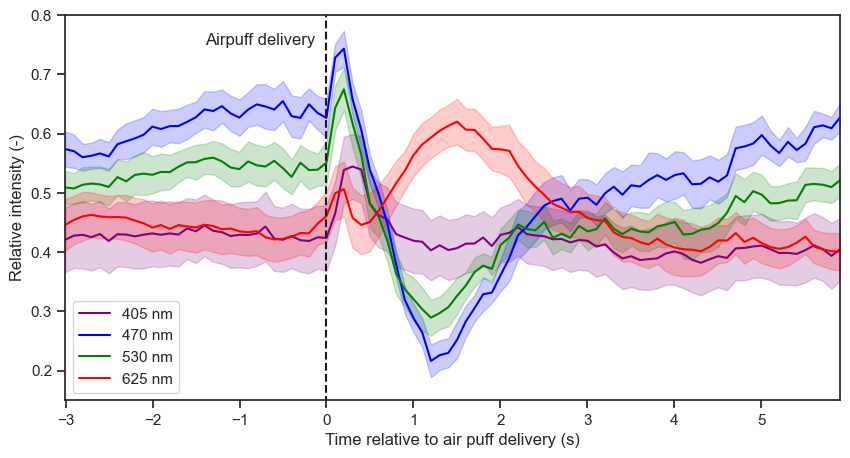

In [40]:
times = (violet_t, blue_t, green_t, red_t)
sigs = (violet, blue, green, red)
cols = ('purple', 'blue', 'green', 'red')
legs = ('405 nm', '470 nm', '530 nm', '625 nm')

# times = ( blue_t, violet_t,green_t, red_t)
# sigs = ( blue, violet,green, red)
# # cols = ( 'blue','purple', 'green', 'red')
# cols = ('lightcyan', 'plum', 'honeydew', 'pink')
# legs = ( '470 nm','405 nm', '530 nm', '625 nm')

inf = 30
sup = 60

# avg_data = np.mean(aligned_data, axis=0)
# std_data = sem(aligned_data, axis=0)

fig = plt.figure(figsize=(10, 5))

sns.set_theme(style='ticks')

for time, sig, col, leg in zip(times, sigs, cols, legs):
  # AP
  AP_idx = []
  nChannels=5
  AP_begin = 5
  percycle=15
  FPSc = FPS/nChannels
  framespcycles = int(FPSc*percycle)
  ncycles = int(len(time)//framespcycles)
  AP_times = np.array(list(range(ncycles)))*15+5
  for ti in AP_times:
      AP_idx.append(np.argmin(np.absolute(time-ti)))
  # Data
  aligned_data = np.zeros((len(AP_idx), inf+sup))
  for i in range(len(AP_idx)):
    aligned_data[i,:] = sig[int(AP_idx[i]-inf):int(AP_idx[i]+sup)]
  avg_data = np.mean(aligned_data, axis=0)
  std_data = sem(aligned_data, axis=0)
  plt.plot(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data, color=col, label=leg)
  plt.fill_between(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data-std_data, avg_data+std_data, alpha=0.2, color=col)
# sns.despine()
plt.legend()
plt.text(-1.4, 0.75, 'Airpuff delivery')
plt.vlines(0, 0, 1, color='k', linestyles='--')
plt.xlabel('Time relative to air puff delivery (s)')
plt.ylabel('Relative intensity (-)')
plt.ylim(0.15, 0.8)
plt.xlim(time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup-1]-time[AP_idx[0]])
# plt.savefig('4sigaligned.png', dpi=600)
plt.show()

## Computed hb

### complete time series

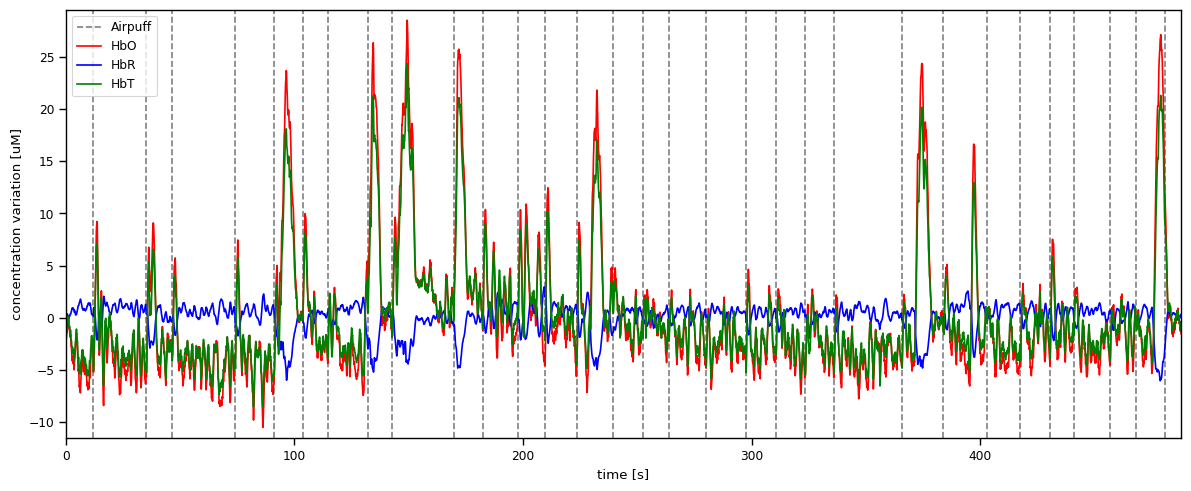

In [34]:
# open data
sns.set_context('paper')

# folder_path = r"C:\Users\gabri\Desktop\testAnalyse\2024_07_18"
folder_path = r"Z:\gGermain\2014_09_17\3"
HbO, HbR, HbT = np.load(folder_path + "\\computedHb.npy")
timestamps = np.load(folder_path + "\\625ts.npy")

# AP approx
# ncycles = int((np.max(timestamps)-5) // 15)
# AP = np.array(list(range(ncycles+1))) * 15 + 5
AP = np.array([  12.01,   35.2 ,   46.51,   74.12,   91.14,  103.63,  114.48,
        132.14,  142.77,  169.61,  182.33,  197.83,  209.56,  223.5 ,
        239.35,  252.31,  263.77,  279.97,  297.53,  310.62,  323.38,
        335.92,  365.67,  383.93,  402.83,  417.51,  430.48,  440.9 ,
        456.7 ,  468.25,  480.64])

fig = plt.figure(figsize=(12,5))
plt.vlines(AP, np.min(HbO)-1, np.max(HbO)+1, color='grey', linestyles='--', label="Airpuff")
plt.plot(timestamps, HbO, 'r-', label="HbO")
plt.plot(timestamps, HbR, 'b-', label="HbR")
plt.plot(timestamps, HbT, 'g-', label="HbT")
plt.legend()
plt.xlabel('time [s]')
plt.xlim(timestamps.min(), timestamps.max())
plt.ylim(np.min(HbO)-1, np.max(HbO)+1)
plt.ylabel('concentration variation [uM]')
# sns.despine()
plt.tight_layout()
plt.show()


### Prep data

In [41]:
time = timestamps
sigs = (HbO, HbR, HbT)
# titles = ("HbO", "HbR", "HbT")
titles = ("Oxygenated hemoglobin [HbO]", "Deoxygenated hemoglobin [HbR]", "Total hemoglobin [HbT]")
cols = ('red', 'royalblue', 'green')
cmaps = (clm['Reds_r'], clm['Blues_r'], clm['Greens_r'])

FPS = 50
AP_idx = []
# nChannels =5
# AP_begin = 5
# percycle = 15
# FPSc = FPS/nChannels
# framespcycles = int(FPSc*percycle)
# ncycles = int(len(time)//framespcycles)
# AP_times = np.array(list(range(ncycles)))*15+5
AP_times = np.array([  12.01,   35.2 ,   46.51,   74.12,   91.14,  103.63,  114.48,
        132.14,  142.77,  169.61,  182.33,  197.83,  209.56,  223.5 ,
        239.35,  252.31,  263.77,  279.97,  297.53,  310.62,  323.38,
        335.92,  365.67,  383.93,  402.83,  417.51,  430.48,  440.9 ,
        456.7 ,  468.25])#,  480.64])
ncycles = len(AP_times)

## AIRPUFFS
for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(time-ti)))
# Dirac où AP dans times series
AP_series = np.zeros(len(time))
AP_series[AP_idx] = 1

## ALIGN DATA
inf = 30
sup = 100
aligned_data_raw = np.zeros((len(sigs), len(AP_idx), inf+sup))
aligned_data_norm = np.zeros((len(sigs), len(AP_idx), inf+sup))
for idx, sig in enumerate(sigs):
  for i in range(len(AP_idx)):
    plage = sig[int(AP_idx[i]-inf):int(AP_idx[i]+sup)]
    aligned_data_raw[idx,i,:] = plage
    aligned_data_norm[idx,i,:] = (plage-np.min(plage))/(np.max(plage)-np.min(plage))

  aligned_data = aligned_data_raw

### raster

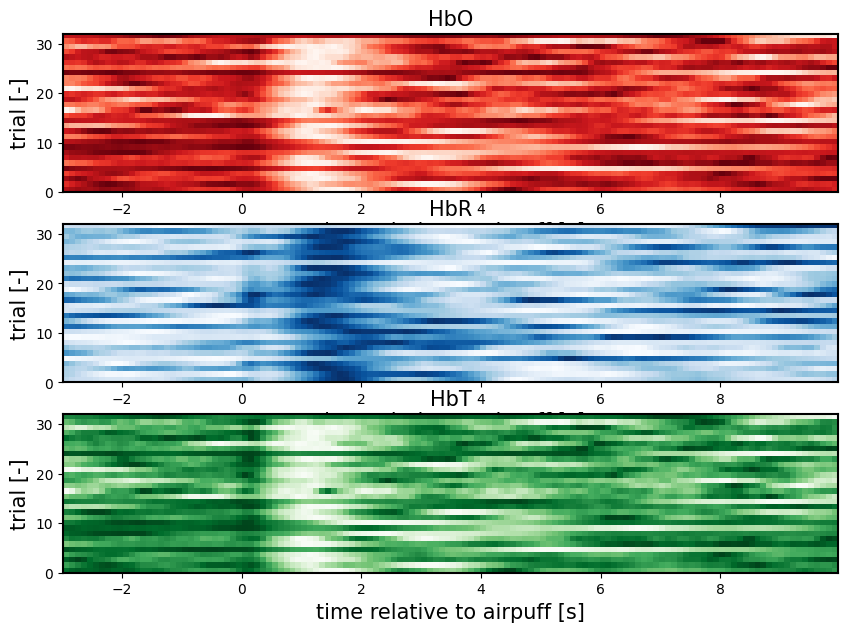

In [34]:
fig = plt.figure(figsize=(10, 7))
for idx, (sig, cmap, title) in enumerate(zip(aligned_data, cmaps, titles)):
  ax = plt.subplot(3, 1, idx+1)
  ax.set_title(title)
  ax.set_xlabel('time relative to airpuff [s]')
  ax.set_ylabel("trial [-]")
  ax.imshow(aligned_data_norm[idx,:,:], origin='lower', extent=[time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]], 0, ncycles], aspect='auto', cmap=cmap)


### moyenne

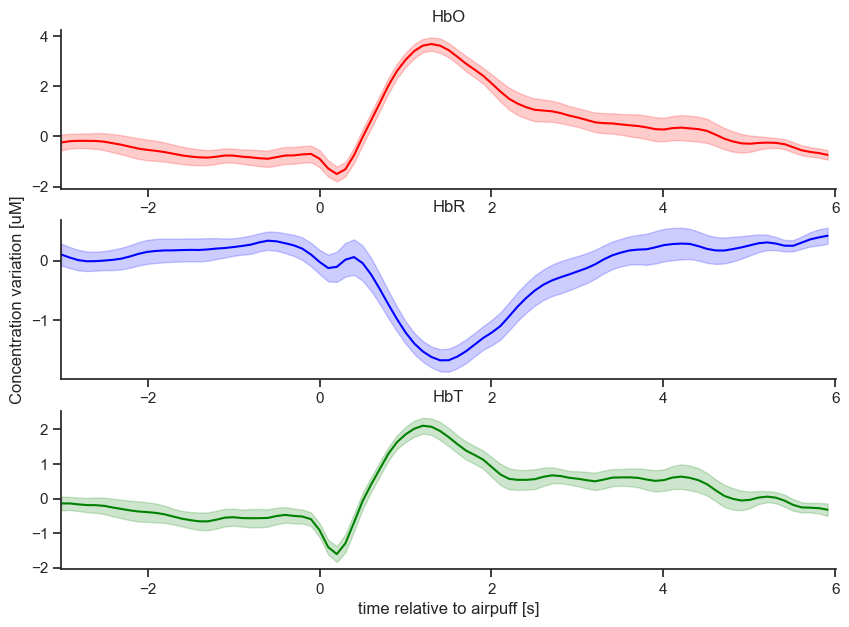

In [21]:
fig = plt.figure(figsize=(10, 7))
for idx, (sig, col, title) in enumerate(zip(aligned_data_raw, cols, titles)):
    avg_data = np.mean(sig, axis=0)
    std_data = sem(sig, axis=0)

    ax = plt.subplot(3, 1, idx+1)
    ax.set_title(title)
    # ax.vlines(0, avg_data.min(), avg_data.max(), color='grey', linestyles='-')
    ax.plot(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data, color=col)
    ax.fill_between(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data-std_data, avg_data+std_data, color=col, alpha=0.2)
    ax.set_xlim(time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]])
    ax.set_xlabel('time relative to airpuff [s]')
    if idx == 1:
        ax.set_ylabel("Concentration variation [uM]")
    sns.despine()


### combined raster + average

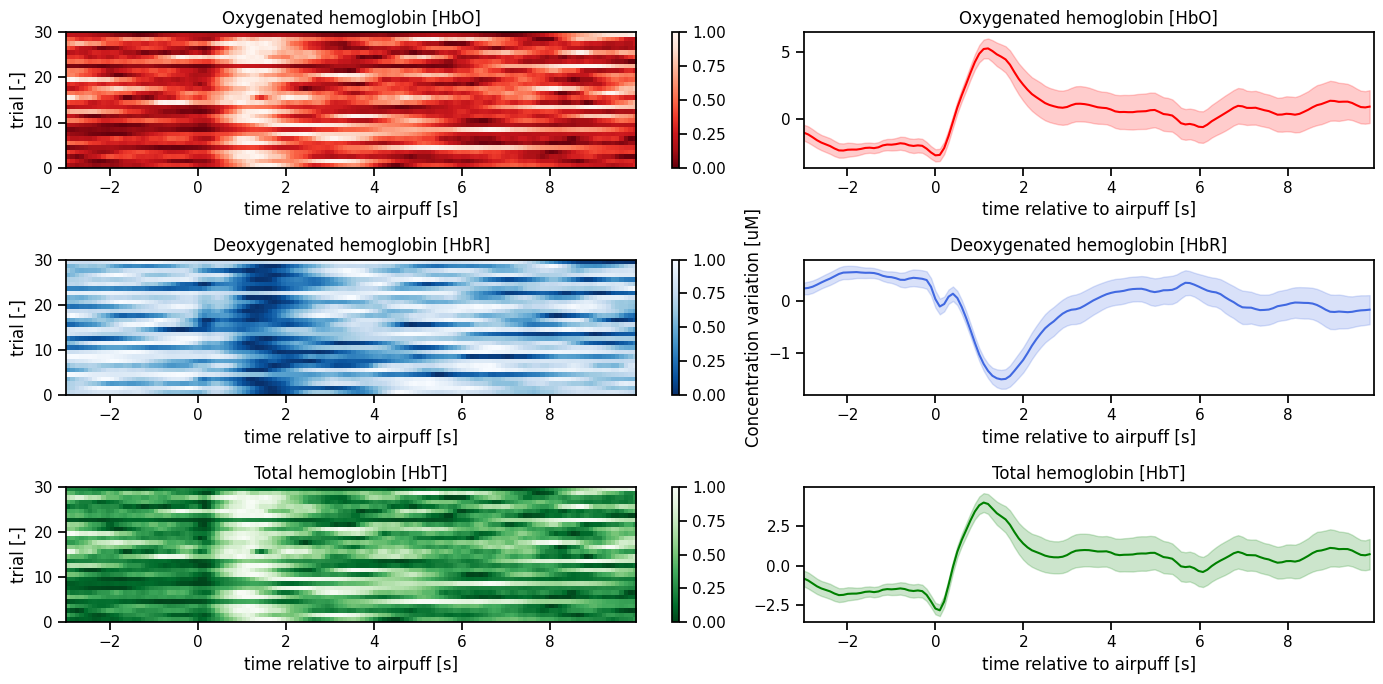

In [43]:
# fig = plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(3, 2, figsize=(14,7), width_ratios=[5, 4])
sns.set_context('notebook')

for idx, (sig, cmap, title) in enumerate(zip(aligned_data, cmaps, titles)):
  ax = plt.subplot(3, 2, 2*idx+1)
  ax.set_title(title)
  ax.set_xlabel('time relative to airpuff [s]')
  ax.set_ylabel("trial [-]")
  pos = ax.imshow(aligned_data_norm[idx,:,:], origin='lower', extent=[time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]], 0, ncycles], aspect='auto', cmap=cmap)
  fig.colorbar(pos, ax=ax)

for idx, (sig, col, title) in enumerate(zip(aligned_data_raw, cols, titles)):
    avg_data = np.mean(sig, axis=0)
    std_data = sem(sig, axis=0)

    ax = plt.subplot(3, 2, 2*idx+2)
    ax.set_title(title)
    # ax.vlines(0, avg_data.min(), avg_data.max(), color='grey', linestyles='-')
    ax.plot(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data, color=col)
    ax.fill_between(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data-std_data, avg_data+std_data, color=col, alpha=0.2)
    ax.set_xlim(time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]])
    ax.set_xlabel('time relative to airpuff [s]')
    if idx == 1:
        ax.set_ylabel("Concentration variation [uM]")
    # sns.despine()
    plt.tight_layout()

### Correlation

2578
1.4027999999999885 1.5029999999999877 1.3025999999999893


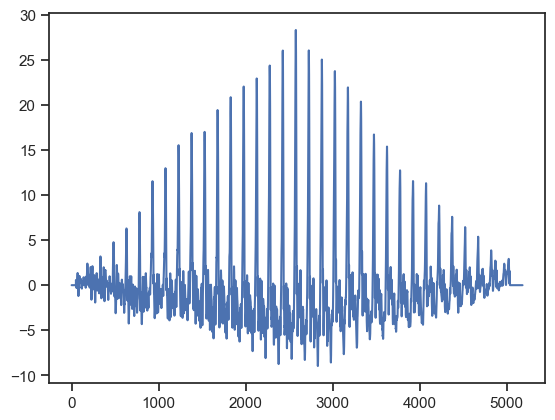

In [53]:
correlation_HbO = correlate(AP_series, HbO)
correlation_HbR = correlate(AP_series, -HbR)   # anticorrélé
correlation_HbT = correlate(AP_series, HbT)

lag_HbO = (len(AP_series) - np.argmax(correlation_HbO))*time[1]
lag_HbR = (len(AP_series) - np.argmax(correlation_HbR))*time[1]
lag_HbT = (len(AP_series) - np.argmax(correlation_HbT))*time[1]

plt.plot(correlation_HbR)
# print(np.argmax(correlation_HbR))
# plt.xlim(2450, 2700)

print(lag_HbO, lag_HbR, lag_HbT)

